In [401]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
stops = set(stopwords.words('russian'))
import string
punctuation = string.punctuation + '–'
import re

import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 0. Load data

This data was lighly processed in the Rmarkdown notebook `Basic-Features.Rmd`. 

In [253]:
train = pd.read_csv("../data/basic_features/train.csv")
test = pd.read_csv("../data/basic_features/test.csv")

In [254]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_character_count_log,description_missing,price_mising,image_missing,param_1_missing,param_2_missing,param_3_missing,param_1_freq,param_2_freq,param_3_freq
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,4.077537,False,False,False,False,True,True,0.004292,0.441268,0.581002
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3.737670,False,False,False,False,True,True,0.018966,0.441268,0.581002
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,4.605170,False,False,False,False,True,True,0.001430,0.441268,0.581002
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,3.135494,False,False,False,False,True,True,0.003416,0.441268,0.581002
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,3.218876,False,False,False,False,False,False,0.041317,0.013153,0.001273


In [255]:
test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,description_character_count_log,description_missing,price_mising,image_missing,param_1_missing,param_2_missing,param_3_missing,param_1_freq,param_2_freq,param_3_freq
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,...,2.564949,False,True,False,False,False,False,0.075915,0.099026,0.004463
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,...,4.488636,False,False,True,False,True,True,0.001253,0.441268,0.581002
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,...,4.890349,False,False,False,False,True,True,0.005112,0.441268,0.581002
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,...,4.543295,False,False,True,False,False,True,0.010668,0.000281,0.581002
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,...,4.110874,False,False,False,False,True,True,0.017852,0.441268,0.581002


## 1. More extensive character/word level features.

In the first round of features, I extracted word counts and character counts. There is more to do here, however. 

First, however, I've noticed that there are no examples with missing descriptions in the test data. As such, features learned on the training data (which have missing descriptions) may not generalize to the test data.

As such, I'll drop all the rows that have missing descriptions in the training data. **Note to self: This is a strong move. Come back and try not removing them!!!**

In [256]:
train.shape

(1503424, 37)

In [257]:
# remove training examples with missing descriptions
train = train.loc[np.logical_not(pd.isnull(train.description))]

In [258]:
train.shape # dropped around 200,000 examples - ~15%. 

(1387148, 37)

##### Number/proportion of non-alphanumeric characters in the title/description

In [259]:
# number of non-alphanumeric characters in title
train["num_nonalphanum_title"] = train.title.apply(lambda x: len([c for c in x if c != " " and not c.isalnum()]))
test["num_nonalphanum_title"] = test.title.apply(lambda x: len([c for c in x if c != " " and not c.isalnum()]))

In [260]:
# proportion of title that is non-alphanumeric
train["prop_nonalphanum_title"] = train.apply(lambda row: row["num_nonalphanum_title"]/len(row.title), axis = 1)
test["prop_nonalphanum_title"] = test.apply(lambda row: row["num_nonalphanum_title"]/len(row.title), axis = 1)

In [261]:
def num_nonalphanum_chars(row,col):
    return len([c for c in row[col] if c != " " and not c.isalnum()])

In [262]:
train["num_nonalphanum_desc"] = train.apply(lambda row: num_nonalphanum_chars(row, "description"), axis = 1)
test["num_nonalphanum_desc"] = test.apply(lambda row: num_nonalphanum_chars(row, "description"), axis = 1)

In [263]:
train["prop_nonalphanum_desc"] = train.apply(lambda row: row.num_nonalphanum_desc / len(row.description), axis = 1)
test["prop_nonalphanum_desc"] = test.apply(lambda row: row.num_nonalphanum_desc / len(row.description), axis = 1)

##### Number/proportion of numeric characthers in title/description

In [264]:
test["num_numeric_title"] = test.title.apply(lambda x: len([c for c in x if c.isnumeric()]))
train["num_numeric_title"] = train.title.apply(lambda x: len([c for c in x if c.isnumeric()]))

In [265]:
train["prop_numeric_title"] = train.apply(lambda row: row["num_numeric_title"]/len(row["title"]), axis = 1)
test["prop_numeric_title"] = test.apply(lambda row: row["num_numeric_title"]/len(row["title"]), axis = 1)

In [266]:
# number of numeric characters in description
test["num_numeric_desc"] = test.description.apply(lambda x: len([c for c in x if c.isnumeric()]))
train["num_numeric_desc"] = train.description.apply(lambda x: len([c for c in x if c.isnumeric()]))

In [267]:
# proportion of numeric characters in description
train["prop_numeric_desc"] = train.apply(lambda row: row["num_numeric_desc"]/len(row["description"]), axis = 1)
test["prop_numeric_desc"] = test.apply(lambda row: row["num_numeric_desc"]/len(row["description"]), axis = 1)

##### Title word count

In [268]:
test["title_word_count"] = test.title.apply(lambda x: len(x.split()))
train["title_word_count"] = train.title.apply(lambda x: len(x.split()))

##### Number of **unique** words it title/description

In [269]:
test["title_unique_word_count"] = test.title.apply(lambda x: len(set(x.split())))
train["title_unique_word_count"] = train.title.apply(lambda x: len(set(x.split())))

##### Number of repeated words in title

In [270]:
train["title_num_repeated_words"] = train.apply(lambda row: row.title_word_count - row.title_unique_word_count, axis = 1)
test["title_num_repeated_words"] = test.apply(lambda row: row.title_word_count - row.title_unique_word_count, axis = 1)

## 2. Group Features

In [271]:
# put all the data in one place
df = pd.concat([train.drop("deal_probability", axis = 1), test])

#### Mean/median price inside a parent category

In [272]:
parent_category_grouped = df.groupby("parent_category_name")

In [273]:
parent_category_grouped_price_metrics = parent_category_grouped["price"].agg(
    [("category_mean_price", 'mean'), ('category_median_price', 'median')])

In [274]:
train = pd.merge(train, parent_category_grouped_price_metrics, left_on = "parent_category_name", right_index=True)

In [275]:
test = pd.merge(test, parent_category_grouped_price_metrics, left_on = "parent_category_name", right_index=True)

##### Difference between price and mean/median price

In [276]:
test["price_category_mean_diff"] = test.apply(lambda row: row.price - row.category_mean_price, axis = 1)
train["price_category_mean_diff"] = train.apply(lambda row: row.price - row.category_mean_price, axis = 1)

In [277]:
test["price_category_median_diff"] = test.apply(lambda row: row.price - row.category_median_price, axis = 1)
train["price_category_median_diff"] = train.apply(lambda row: row.price - row.category_median_price, axis = 1)

#### Median `image_top_1` in parent category group

This is motivated by the relationship that I found between `image_top_1` and `parent_category_grouped`

In [278]:
parent_category_grouped_median_image = parent_category_grouped["image_top_1"].agg(
[('category_median_image_top_1', 'median')])

In [279]:
train = pd.merge(train, parent_category_grouped_median_image, left_on = "parent_category_name", right_index=True)

In [280]:
test = pd.merge(test, parent_category_grouped_median_image, left_on = "parent_category_name", right_index=True)

In [281]:
test[['parent_category_name', 'image_top_1', "category_median_image_top_1"]].head()

,parent_category_name,image_top_1,category_median_image_top_1
0,Личные вещи,2020.0,432.0
4,Личные вещи,1002.0,432.0
9,Личные вещи,88.0,432.0
13,Личные вещи,658.0,432.0
17,Личные вещи,30.0,432.0


In [282]:
train["image_top1_category_median_diff"] = train.apply(lambda row: row.image_top_1 - row.category_median_image_top_1, axis = 1)
test["image_top1_category_median_diff"] = test.apply(lambda row: row.image_top_1 - row.category_median_image_top_1, axis = 1)

## 3. Tf-Idf features

###### Presence of high tf-idf words

In [283]:
def get_prob_group(prob):
    if prob == 0:
        return "zero"
    elif prob < .27:
        return "low"
    elif prob < .7:
        return "mid"
    elif prob < 1:
        return "high"
    else:
        return "certain"

In [284]:
# bin the probabilities
train['prob_group'] = train.deal_probability.map(lambda x: get_prob_group(x))

Now, I'll put all the titles and descriptions in one place

##### Bi-gram Tf-Idf title features

In [285]:
# first, remove words with numbers
tmp = train
tmp.title = tmp.title.apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())

In [286]:
# gather the words simply based on the probability group they're in. 
prob_group_words = train.groupby('prob_group')['title'].apply(
    lambda x: " ".join(list(x))).reset_index()  

In [287]:
prob_group_bigram_vect = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

In [288]:
prob_group_bigram_tfidf = prob_group_bigram_vect.fit_transform(prob_group_words.title.values)

In [289]:
reverse_vocab_prob_group_bigram = {k:v for v, k in prob_group_bigram_vect.vocabulary_.items()}

Now, a function that takes in a tf-idf matrix, and returns a set of the top `n` tf-idf words from eachg group

In [290]:
def build_top_set(tfidf_matrix, reverse_vocab, top = 3):
    top_words = set()
    for doc in range(tfidf_matrix.shape[0]):
        top_indecies = np.asarray(tfidf_matrix[doc].todense()).argsort().reshape((-1,))[-top:]
        for ind in top_indecies:
            top_words.add(reverse_vocab[ind])
    return top_words

In [291]:
top_bigrams_probgroup = build_top_set(prob_group_bigram_tfidf, reverse_vocab_prob_group_bigram, top = 15)

In [292]:
top_bigrams_probgroup

{'iphone',
 'samsung',
 'авто',
 'аренда',
 'аренду',
 'ботинки',
 'ваз',
 'велосипед',
 'газель',
 'грузоперевозки',
 'грузчики',
 'диван',
 'дом',
 'дом м²',
 'квартир',
 'квартира',
 'квартира м²',
 'коляска',
 'комбинезон',
 'костюм',
 'куртка',
 'м²',
 'м² участке',
 'м² эт',
 'мастер',
 'наращивание',
 'новые',
 'пальто',
 'платье',
 'продам',
 'работы',
 'ремонт',
 'репетитор',
 'сапоги',
 'сот',
 'строительство',
 'туфли',
 'услуги',
 'установка',
 'участке',
 'участке сот',
 'участок',
 'участок сот',
 'эт',
 'эт квартира'}

In [297]:
# annoying leftover stopwords
top_bigrams_probgroup.remove("эт")
top_bigrams_probgroup.remove("сот")

In [294]:
def add_title_token_cols(df, tokens):
    for token in tokens:
        colname = "contains_" + token.replace(" ", "_")
        df[colname] = df.title.apply(lambda x: token in x.lower())
    return df

In [295]:
train = add_title_token_cols(train, top_bigrams_probgroup)
test = add_title_token_cols(test, top_bigrams_probgroup)

##### Projected dimensionality of Tf-Idf vectors

Credits to Sadalairaj Kumar in his [great EDA kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-notebook-avito/code) for this idea.

In [298]:
# tf-idf tokenizer for the titles from previous section (unigrams and bigrams)
prob_group_bigram_vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'у', 'какая', 'конечно', 'моя', 'на', 'теперь', 'со', 'надо', 'нее', 'она', 'только', 'их', 'я', 'при', 'чем', 'лучше', 'так', 'никогда', 'вот', 'здесь', 'совсем', 'нет', 'от', 'ни', 'но', 'два', 'как', 'об', 'чтоб', 'для', 'него', 'ты', 'хорошо', 'мне', 'мы', 'меня', 'разве', 'всех', 'л...ь', 'если', 'он', 'ее', 'же', 'из', 'будет', 'когда', 'них', 'с', 'в', 'быть', 'уже', 'раз', 'ведь'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [299]:
# get a tf-idf embedding of the entire dataset (train + test) for the titles
full_title_tfidf = prob_group_bigram_vect.transform(df.title)

In [219]:
full_title_tfidf #sparse matrix

<1895586x1513267 sparse matrix of type '<class 'numpy.float64'>'
	with 7340502 stored elements in Compressed Sparse Row format>

In [300]:
# fit a Singular Value Decomposition projection onto this tf-idf matrix
title_svd = TruncatedSVD(n_components=5, algorithm='arpack')
title_svd.fit(full_title_tfidf)

TruncatedSVD(algorithm='arpack', n_components=5, n_iter=5, random_state=None,
       tol=0.0)

In [320]:
train_svd = pd.DataFrame(title_svd.transform(prob_group_bigram_vect.transform(train.title)), index = train.index)
test_svd = pd.DataFrame(title_svd.transform(prob_group_bigram_vect.transform(test.title)), index = test.index)

In [321]:
train_svd.columns = ['svd_title_'+str(i+1) for i in range(5)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(5)]

In [328]:
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)

In [351]:
del full_title_tfidf, train_svd, test_svd

## 4. Integer encoding categorical variables

#### Parent category

In [332]:
parent_category_enc = LabelEncoder()

In [333]:
parent_category_enc.fit(np.append(train['parent_category_name'],test['parent_category_name']).reshape(-1,1))

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [334]:
train['parent_category_int'] = parent_category_enc.transform(train.parent_category_name)
test['parent_category_int'] = parent_category_enc.transform(test.parent_category_name)

###### User type

In [335]:
user_type_enc = LabelEncoder()

In [336]:
user_type_enc.fit(np.append(test.user_type, train.user_type))

LabelEncoder()

In [337]:
train['user_type_int'] = user_type_enc.transform(train.user_type)
test['user_type_int'] = user_type_enc.transform(test.user_type)

##### Region

In [338]:
region_enc = LabelEncoder()

In [339]:
region_enc.fit(np.append(train.region, test.region))

LabelEncoder()

In [340]:
train['region_int'] = region_enc.transform(train.region)
test['region_int'] = region_enc.transform(test.region)

##### City

In [341]:
city_enc = LabelEncoder()

In [342]:
city_enc.fit(np.append(train.city, test.city))

LabelEncoder()

In [343]:
train['city_int'] = city_enc.transform(train.city)
test['city_int'] = city_enc.transform(test.city)

##### weekday

In [411]:
train["weekday_int"] = pd.to_datetime(train.activation_date).dt.weekday
test["weekday_int"] = pd.to_datetime(test.activation_date).dt.weekday

## 5. Fill missing values

In [413]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(train.isnull().sum(axis=0))

item_id                                 0
user_id                                 0
region                                  0
city                                    0
parent_category_name                    0
category_name                           0
param_1                             58117
param_2                            605372
param_3                            803213
title                                   0
description                             0
price                                   0
item_seq_number                         0
activation_date                         0
user_type                               0
image                              109325
image_top_1                             0
deal_probability                        0
days_since_previous_appearence          0
days_since_previous_appearence2         0
avg_appearences_per_day_prev            0
daily_ad_number                         0
daily_ad_number_category                0
city_frequency                    

In [358]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(test.isnull().sum(axis=0))

item_id                                 0
user_id                                 0
region                                  0
city                                    0
parent_category_name                    0
category_name                           0
param_1                             22910
param_2                            233229
param_3                            306331
title                                   0
description                             0
price                               30585
item_seq_number                         0
activation_date                         0
user_type                               0
image                               42609
image_top_1                         42609
days_since_previous_appearence     306069
days_since_previous_appearence2    381306
avg_appearences_per_day_prev       466272
daily_ad_number                         0
daily_ad_number_category                0
city_frequency                          0
title_word_count                  

##### Price

In [361]:
train["price"] = train.price.fillna(-999)
test["price"] = test.price.fillna(-999)

##### `image_top_1`

In [377]:
fillvalue = np.max(df.image_top_1) + 1

In [380]:
train['image_top_1'] = train.image_top_1.fillna(fillvalue)
test['image_top_1'] = test.image_top_1.fillna(fillvalue)

###### days_since_previous_appearence and days_since_previous_appearence2

In [382]:
train['days_since_previous_appearence'] = train.days_since_previous_appearence.fillna(-999)
train['days_since_previous_appearence2'] = train.days_since_previous_appearence2.fillna(-999)
test['days_since_previous_appearence'] = test.days_since_previous_appearence.fillna(-999)
test['days_since_previous_appearence2'] = test.days_since_previous_appearence2.fillna(-999)

###### avg_appearences_per_day_prev

In [384]:
train["avg_appearences_per_day_prev"] = train.avg_appearences_per_day_prev.fillna(-999)
test["avg_appearences_per_day_prev"] = test.avg_appearences_per_day_prev.fillna(-999)

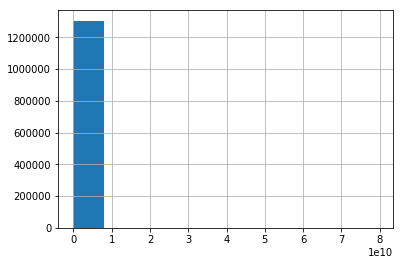

In [386]:
train.price_category_mean_diff.hist()

##### `price_category_mean_diff` and `price_category_median_diff`

In [389]:
train["price_category_mean_diff"] = train.price_category_mean_diff.fillna(-999)
test["price_category_mean_diff"] = test.price_category_mean_diff.fillna(-999)

In [391]:
train["price_category_median_diff"] = train.price_category_median_diff.fillna(-999)
test["price_category_median_diff"] = test.price_category_median_diff.fillna(-999)

##### `image_top1_category_median_diff`

In [398]:
train["image_top1_category_median_diff"] = train.image_top1_category_median_diff.fillna(-10000)
test["image_top1_category_median_diff"] = test.image_top1_category_median_diff.fillna(-10000)

## 6. Save data

First, isolating the colums that will make up the training data

In [414]:
list(train.columns)

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'deal_probability',
 'days_since_previous_appearence',
 'days_since_previous_appearence2',
 'avg_appearences_per_day_prev',
 'daily_ad_number',
 'daily_ad_number_category',
 'city_frequency',
 'title_word_count',
 'title_character_count',
 'description_word_count_log',
 'description_character_count_log',
 'description_missing',
 'price_mising',
 'image_missing',
 'param_1_missing',
 'param_2_missing',
 'param_3_missing',
 'param_1_freq',
 'param_2_freq',
 'param_3_freq',
 'num_nonalphanum_title',
 'prop_nonalphanum_title',
 'num_nonalphanum_desc',
 'prop_nonalphanum_desc',
 'num_numeric_title',
 'prop_numeric_title',
 'num_numeric_desc',
 'prop_numeric_desc',
 'title_unique_word_count',
 'title_num_repeated_words',
 'category_mean_price',
 'category_

In [420]:
traincols = set(train.columns)
for col in [
    'item_id',
    'user_id',
    'region',
    'city',
    'parent_category_name',
    'category_name',
    'param_1',
    'param_2',
    'param_3',
    'title',
    'description', 
    'activation_date', 
    'user_type', 
    'image', 
    'deal_probability', 
    'category_mean_price', 
    'category_median_price', 
    'category_median_image_top_1',
    'prob_group',
    ]:
    traincols.remove(col)

In [423]:
mkdir ../data/second_features

In [424]:
with open("../data/second_features/colnames.pkl", "wb") as handle:
    pickle.dump(traincols,handle)

In [425]:
train.to_csv("../data/second_features/train.csv")
test.to_csv("../data/second_features/test.csv")

CPU times: user 9 µs, sys: 11 µs, total: 20 µs
Wall time: 57.9 µs


In [443]:
with open("../data/second_features/y.npy", "wb") as handle:
    np.save(handle, train.deal_probability.values)